In [1]:
import findspark
findspark.init()
import pyspark 
from pyspark import SparkContext
from pyspark.mllib.fpm import FPGrowth
from pyspark.mllib.clustering import KMeans, KMeansModel
import re
import math
from math import sqrt
from random import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '8')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port, os.getcwd().split("/")[2]

4179 wez515


In [3]:
sc = pyspark.SparkContext(appName="Project 3", master='spark://polyp1:7077',conf = config )

# Task #1 


In [4]:
data = sc.textFile("CompleteDataset.csv")
print data.take(5)
header = data.first()
cleandata = data.filter(lambda x: x != header)
print cleandata.take(5)

[u',Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST', u'0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,\u20ac95.5M,\u20ac565K,2228,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW ,89.0,61.0,53.0,82.

In [5]:

indexname = sc.parallelize([header]).flatMap(lambda x: x.split(',')).collect()

print indexname
dic = {}
i = 0
for line in indexname:
    dic[line] = int(i)
    i += 1
    
    
c = len(indexname)
print "I have ",c, "keys"

print dic['Preferred Positions']



[u'', u'Name', u'Age', u'Photo', u'Nationality', u'Flag', u'Overall', u'Potential', u'Club', u'Club Logo', u'Value', u'Wage', u'Special', u'Acceleration', u'Aggression', u'Agility', u'Balance', u'Ball control', u'Composure', u'Crossing', u'Curve', u'Dribbling', u'Finishing', u'Free kick accuracy', u'GK diving', u'GK handling', u'GK kicking', u'GK positioning', u'GK reflexes', u'Heading accuracy', u'Interceptions', u'Jumping', u'Long passing', u'Long shots', u'Marking', u'Penalties', u'Positioning', u'Reactions', u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed', u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys', u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB', u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB', u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF', u'RM', u'RS', u'RW', u'RWB', u'ST']
I have  75 keys
63


In [50]:
print dic['ID']

52


In [6]:
print dic['Acceleration']
print dic['Volleys']

13
46


In [6]:
Rows = cleandata.count()
Columns = sc.parallelize([header]).map(lambda x : x.split(','))\
            .map(lambda x: len(x)).collect()[0]
print 'There are %d rows and %d columns in the data file'%(Rows,Columns)

There are 17981 rows and 75 columns in the data file


In [37]:
# Average age 
Age = cleandata.map(lambda x: int(x.split(',')[2]))
print Age.take(5)
AverAge = Age.reduce(lambda x,y: x+y)/float(Rows)
print AverAge
AgeList = Age.collect()
Max = max(AgeList)
print Max
Min = min(AgeList)
print Min
Min = cleandata.filter(lambda x: int(x.split(',')[2]) == 16).map(lambda x: x.split(',')[1])
print Min.take(100)
Max = cleandata.filter(lambda x: int(x.split(',')[2]) == 47).map(lambda x: x.split(',')[1])
print Max.take(100)

[32, 30, 25, 30, 31]
25.1445414604
47
16
[u'K. Pierie', u'A. Gomes', u'E. Vignato', u'G. McEachran', u'L. Geertruida', u'Javi V\xe1zquez', u'J. Romero', u'E. H\xe5land', u'M. Sprang', u'R. Strechie', u'L. Pintor', u'V. Barbero', u'J. Hove']
[u'B. Richardson']


In [40]:
# Task 1.2 find the average overall score group by the age from 21 to 40
ScoreByAge = cleandata.map(lambda x: x.split(','))\
                      .filter(lambda x: int(x[2]) <= 40 and int(x[2]) >= 21)\
                      .map(lambda x : [x[2],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByAge.take(20)
print '\n'
ScoreByAgetop1000 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) <= 999)\
                      .filter(lambda x: int(x[2]) <= 40 and int(x[2]) >= 21)\
                      .map(lambda x : [x[2],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByAgetop1000.take(20)



[(u'30', 69.84701492537313), (u'31', 69.76751117734725), (u'29', 69.72256913470116), (u'33', 69.70988654781199), (u'32', 69.46837944664031), (u'35', 69.15183246073299), (u'36', 69.08088235294117), (u'28', 69.058039961941), (u'27', 68.94357638888889), (u'34', 68.91176470588235), (u'38', 68.66666666666667), (u'26', 68.64392678868552), (u'37', 68.53623188405797), (u'25', 68.00854139290408), (u'39', 67.9), (u'40', 67.625), (u'24', 67.18290854572713), (u'23', 66.11764705882354), (u'22', 64.76208459214502), (u'21', 63.3950233281493)]


[(u'39', 83.5), (u'32', 81.46153846153847), (u'30', 81.36144578313252), (u'34', 81.05555555555556), (u'28', 80.83157894736843), (u'31', 80.76119402985074), (u'29', 80.56470588235294), (u'25', 80.43820224719101), (u'35', 80.3125), (u'27', 80.25773195876289), (u'26', 80.25714285714285), (u'33', 80.25641025641026), (u'23', 80.05970149253731), (u'24', 79.97560975609755), (u'21', 79.89655172413794), (u'36', 79.85714285714286), (u'22', 79.65306122448979), (u'38', 78

In [31]:
ScoreByAgetop1000 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) == 4)\
                      .map(lambda x: x[63]=='GK ')
print ScoreByAgetop1000.take(21)

[True]


In [32]:
ScoreByAgetop1000_2 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) <= 999)\
                      .filter(lambda x: x[63]!='GK ')\
                      .filter(lambda x: int(x[2]) <= 40 and int(x[2]) >= 21)\
                      .map(lambda x : [x[2],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByAgetop1000_2.take(20)

[(u'30', 81.33333333333333), (u'32', 81.27272727272727), (u'34', 81.07692307692308), (u'28', 80.84883720930233), (u'31', 80.73214285714286), (u'29', 80.71052631578948), (u'33', 80.5), (u'25', 80.32098765432099), (u'27', 80.25), (u'26', 80.2127659574468), (u'23', 80.04761904761905), (u'21', 80.03703703703704), (u'36', 79.81818181818181), (u'24', 79.77333333333333), (u'22', 79.71739130434783), (u'35', 79.66666666666667), (u'38', 79.0), (u'39', 78.0), (u'37', 77.5)]


In [37]:
ScoreByAgetop2000 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) <= 1999)\
                      .filter(lambda x: int(x[2]) <= 40 and int(x[2]) >= 21)\
                      .map(lambda x : [x[2],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByAgetop2000.take(20)
print '\n'
ScoreByAgetop2000_2 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) <= 1999)\
                      .filter(lambda x: x[63]!='GK ')\
                      .filter(lambda x: int(x[2]) <= 40 and int(x[2]) >= 21)\
                      .map(lambda x : [x[2],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByAgetop2000_2.take(20)

[(u'39', 80.66666666666667), (u'30', 78.86), (u'32', 78.61538461538461), (u'31', 78.53658536585365), (u'28', 78.48295454545455), (u'35', 78.46428571428571), (u'26', 78.2102564102564), (u'24', 78.125), (u'27', 78.12041884816755), (u'34', 78.04651162790698), (u'36', 78.04), (u'38', 78.0), (u'23', 77.94029850746269), (u'29', 77.90526315789474), (u'25', 77.81313131313131), (u'33', 77.79545454545455), (u'22', 77.6875), (u'21', 77.61194029850746), (u'37', 77.14285714285714), (u'40', 76.0)]


[(u'30', 78.7421875), (u'28', 78.475), (u'31', 78.42056074766356), (u'32', 78.38571428571429), (u'35', 78.3157894736842), (u'34', 78.23333333333333), (u'27', 78.15642458100558), (u'26', 78.1340782122905), (u'36', 78.11111111111111), (u'39', 78.0), (u'24', 77.95804195804196), (u'29', 77.95294117647059), (u'33', 77.93150684931507), (u'23', 77.8984375), (u'25', 77.77094972067039), (u'21', 77.68253968253968), (u'22', 77.66304347826087), (u'38', 77.5), (u'37', 76.66666666666667)]


In [47]:
# Task 1.3 Nationality average score. 
ScoreByNation = cleandata.map(lambda x: x.split(','))\
                      .map(lambda x : [x[4],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).filter(lambda x: x[1][1]>5)\
                      .map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByNation.take(20)


[(u'Syria', 72.5), (u'Israel', 71.16666666666667), (u'Togo', 71.0), (u'Algeria', 70.94736842105263), (u'Chile', 70.896), (u'Brazil', 70.89532019704434), (u'Belarus', 70.77777777777777), (u'Portugal', 70.59945504087193), (u'Ecuador', 70.51351351351352), (u'Gabon', 70.5), (u'Serbia', 70.44360902255639), (u'Czech Republic', 70.17808219178082), (u'Ukraine', 70.04081632653062), (u'Egypt', 69.96875), (u'Spain', 69.93915603532875), (u'Honduras', 69.84615384615384), (u'Moldova', 69.66666666666667), (u'Paraguay', 69.66666666666667), (u'Costa Rica', 69.65517241379311), (u'Morocco', 69.65384615384616)]


In [45]:
ScoreByNation.count()

109

In [56]:
ScoreByNationTop2000 = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[0]) <= 1999)\
                      .map(lambda x : [x[4],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y).filter(lambda x: x[1][1]>5)\
                      .map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByNationTop2000.take(20)

[(u'Belgium', 79.9090909090909), (u'Croatia', 79.83333333333333), (u'Slovenia', 79.5), (u'Poland', 79.4375), (u'Wales', 79.375), (u'Slovakia', 79.16666666666667), (u'Germany', 78.96153846153847), (u'Spain', 78.82905982905983), (u'Bosnia Herzegovina', 78.81818181818181), (u'France', 78.5859872611465), (u'Italy', 78.33613445378151), (u'Uruguay', 78.3103448275862), (u'Greece', 78.25), (u'England', 78.24175824175825), (u'Algeria', 78.1875), (u'Portugal', 78.15730337078652), (u'Senegal', 78.1), (u'Czech Republic', 78.1), (u'Brazil', 78.08), (u'Austria', 78.06666666666666)]


In [58]:
# Task 1.4 Find the top clubs 
ScoreByClub = cleandata.map(lambda x: x.split(','))\
                      .map(lambda x : [x[8],np.array([float(x[6]),1])])\
                      .reduceByKey(lambda x,y: x+y)\
                      .map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print ScoreByClub.take(20)


[(u'FC Barcelona', 82.56), (u'Juventus', 81.65384615384616), (u'Real Madrid CF', 81.03846153846153), (u'FC Bayern Munich', 79.42307692307692), (u'Paris Saint-Germain', 77.96428571428571), (u'Manchester United', 77.70588235294117), (u'Napoli', 77.65384615384616), (u'Roma', 77.37037037037037), (u'Sevilla FC', 76.96153846153847), (u'Inter', 76.72), (u'Chelsea', 76.66666666666667), (u'Sporting CP', 76.28125), (u'FC Porto', 76.09677419354838), (u'Liverpool', 75.875), (u'Atl\xe9tico Madrid', 75.875), (u'Arsenal', 75.75757575757575), (u'Borussia Dortmund', 75.70588235294117), (u'Athletic Club de Bilbao', 75.70370370370371), (u'Be\u015fikta\u015f JK', 75.61538461538461), (u'SL Benfica', 75.54838709677419)]


In [54]:
# ScoreByClubTop = cleandata.map(lambda x: x.split(',')).filter(lambda x :int(x[6]) >60)\
#                       .map(lambda x : [x[8],np.array([float(x[6]),1])])\
#                       .reduceByKey(lambda x,y: x+y).filter(lambda x: x[1][1]>5)\
#                       .map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
#                       .sortBy(lambda x :-x[1])
# print ScoreByClubTop.take(20)

In [59]:
PotentialByClub = cleandata.map(lambda x: x.split(','))\
                      .map(lambda x : [x[8],np.array([float(x[7]),1])])\
                      .reduceByKey(lambda x,y: x+y)\
                      .map(lambda kv: (kv[0], kv[1][0]/kv[1][1]))\
                      .sortBy(lambda x :-x[1])
print PotentialByClub.take(20)

[(u'Real Madrid CF', 85.96153846153847), (u'FC Barcelona', 85.56), (u'FC Bayern Munich', 84.5), (u'Juventus', 84.03846153846153), (u'Paris Saint-Germain', 83.35714285714286), (u'Manchester United', 83.23529411764706), (u'Chelsea', 82.60606060606061), (u'Manchester City', 82.36363636363636), (u'Liverpool', 82.03125), (u'Atl\xe9tico Madrid', 81.96875), (u'Napoli', 81.96153846153847), (u'Borussia Dortmund', 81.70588235294117), (u'Arsenal', 81.63636363636364), (u'Tottenham Hotspur', 81.5625), (u'Milan', 81.27586206896552), (u'Inter', 81.24), (u'Roma', 80.70370370370371), (u'SL Benfica', 80.64516129032258), (u'Bayer 04 Leverkusen', 80.5925925925926), (u'AS Monaco', 80.54545454545455)]


# Task #2 


In [9]:
#Task 2.1 cluster
Position = cleandata.map(lambda x: x.split(',')).map(lambda x : x[63].split()[0])
print Position.take(10)


[u'ST', u'RW', u'LW', u'ST', u'GK', u'ST', u'GK', u'LW', u'CDM', u'ST']


In [20]:
def buildFeatures(line):
    d = line.split(",")
    Key = d[63].split()[0]
    value = []
    for v in d[13:46]:
        v_true = v.split('-')[0]
        v_true = v_true.split('+')[0]
        value.append(float(v_true))
    return Key, value
featureData = cleandata.map(buildFeatures)
print featureData.take(10)

[(u'ST', [89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0]), (u'RW', [92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0]), (u'LW', [94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0]), (u'ST', [88.0, 78.0, 86.0, 60.0, 91.0, 83.0, 77.0, 86.0, 86.0, 94.0, 84.0, 27.0, 25.0, 31.0, 33.0, 37.0, 77.0, 41.0, 69.0, 64.0, 86.0, 30.0, 85.0, 92.0, 93.0, 83.0, 87.0, 38.0, 77.0, 89.0, 45.0, 80.0, 84.0]), (u'GK', [58.0, 29.0, 52.0, 35.0, 48.0, 70.0, 15.0, 14.0, 30.0, 13.0, 11.0, 91.0, 90.0, 95.0, 91.0, 89.0, 25.0, 30.0, 78.0, 59.0, 16.0, 10.0, 47.0, 12.0, 85.0, 55.0, 25.

In [21]:
featureData2 = featureData.map(lambda l: l[1])

print featureData2.take(3)

def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

# Trains a k-means model.
kmax = 20 # You can define any number here you want 
errors = []
for k in range(2,kmax+1):
    print ' %d clusters,' %k
    clusters = KMeans.train(featureData2, k, maxIterations=10, initializationMode="random")
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    WSSSE = featureData2.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    errors.append(WSSSE)
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    

[[89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0], [92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0], [94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0]]
 2 clusters,
Within Set Sum of Squared Error = 1235195.46906
 3 clusters,
Within Set Sum of Squared Error = 1052166.66785
 4 clusters,
Within Set Sum of Squared Error = 948800.059012
 5 clusters,
Within Set Sum of Squared Error = 916974.505607
 6 clusters,
Within Set Sum of Squared Error = 897800.255283
 7 clusters,
Within Set Sum of Squared Error = 857045.142124
 8 clusters,
Within Set Sum of Squared

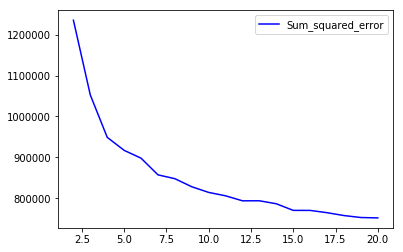

In [22]:
plt.plot(range(2,kmax+1),errors,'b-',label = 'Sum_squared_error')# here you could change b- to r- or anyother color 
plt.legend()

In [ ]:
# we choose k =12 

[(0, u'ST'), (0, u'RW'), (0, u'LW'), (0, u'ST'), (4, u'GK'), (0, u'ST'), (4, u'GK'), (0, u'LW'), (5, u'CDM'), (0, u'ST')]
For cluster 0


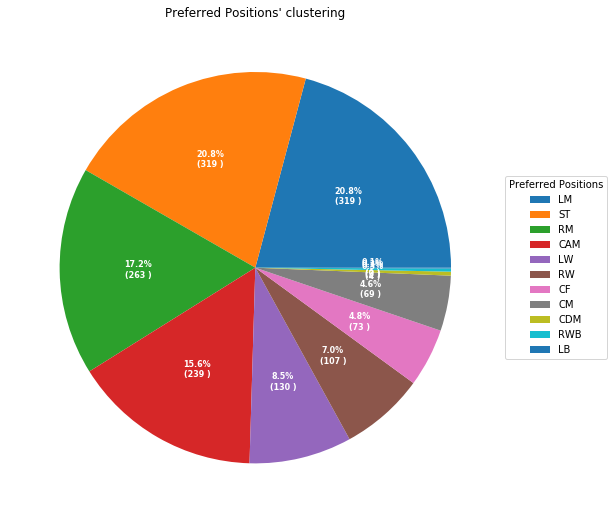

For cluster 1


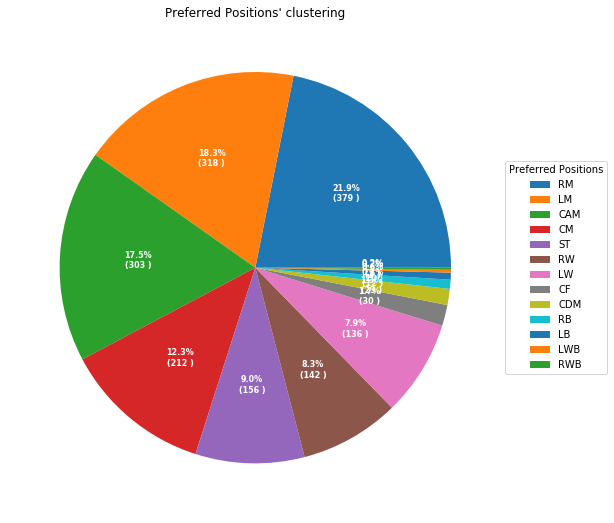

For cluster 2


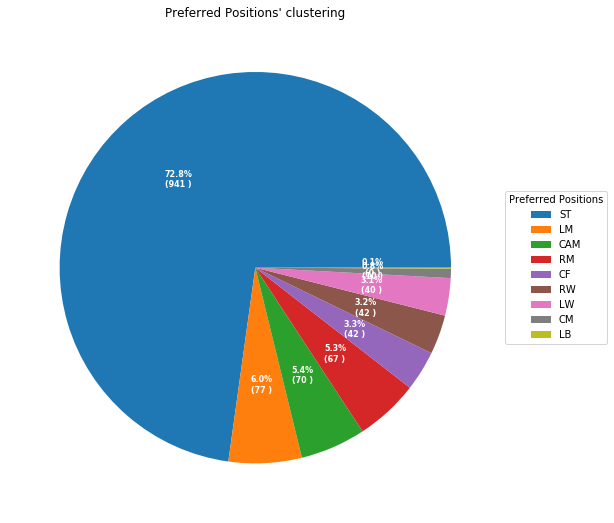

For cluster 3


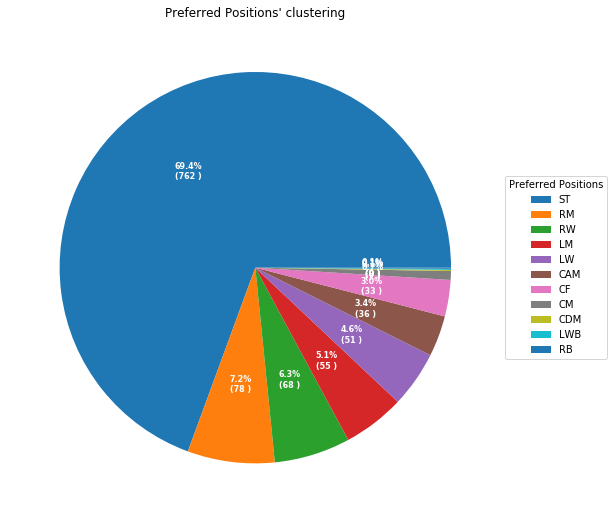

For cluster 4


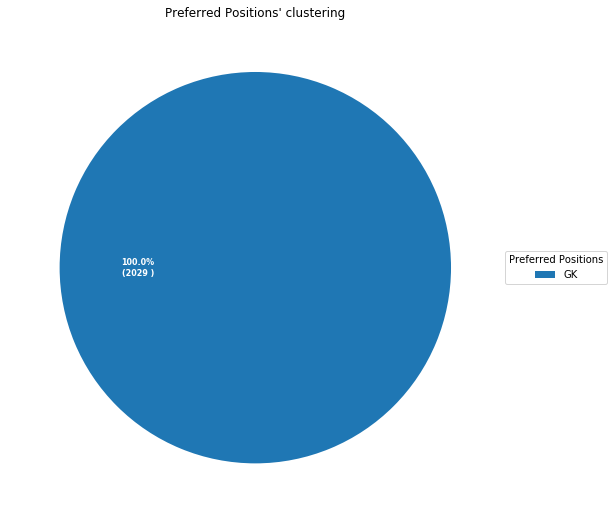

For cluster 5


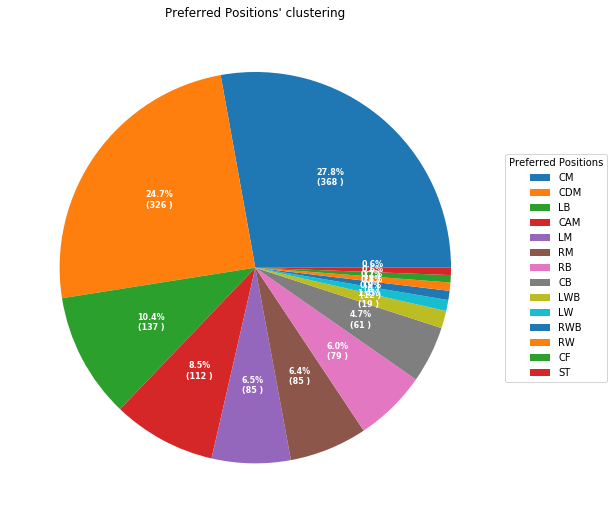

For cluster 6


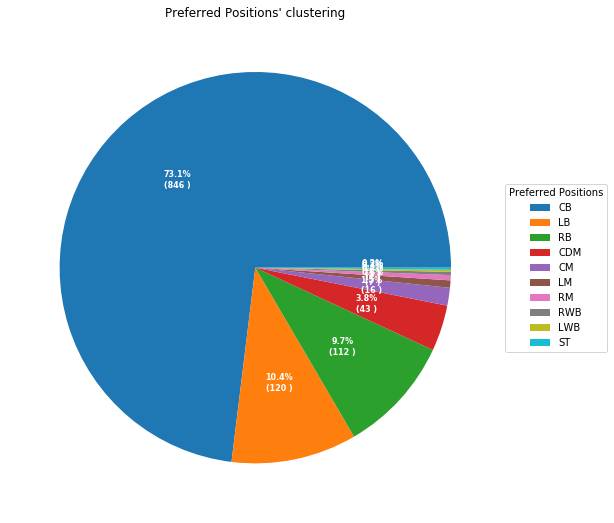

For cluster 7


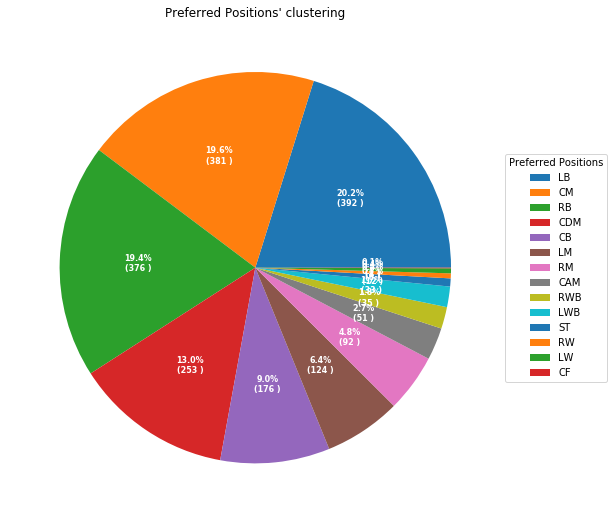

For cluster 8


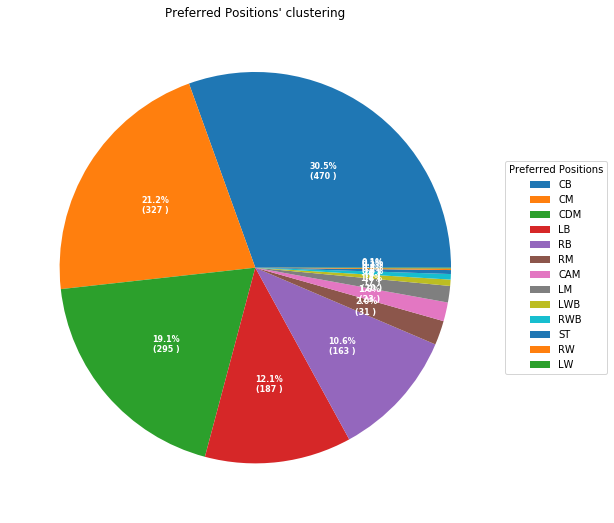

For cluster 9


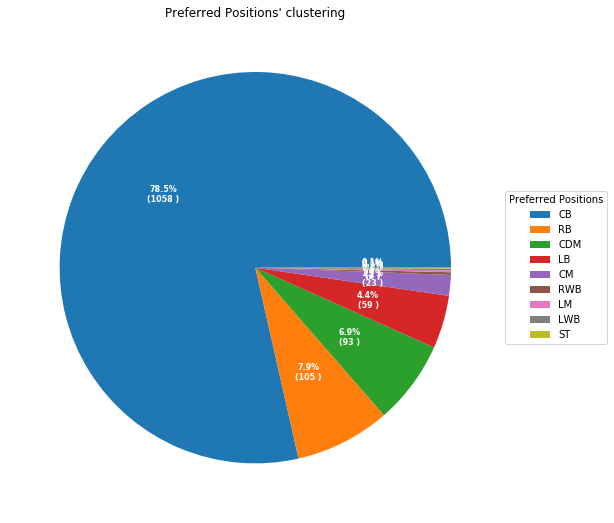

For cluster 10


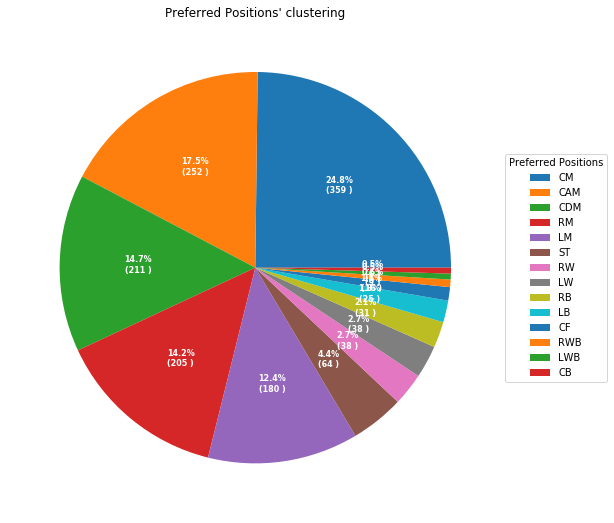

For cluster 11


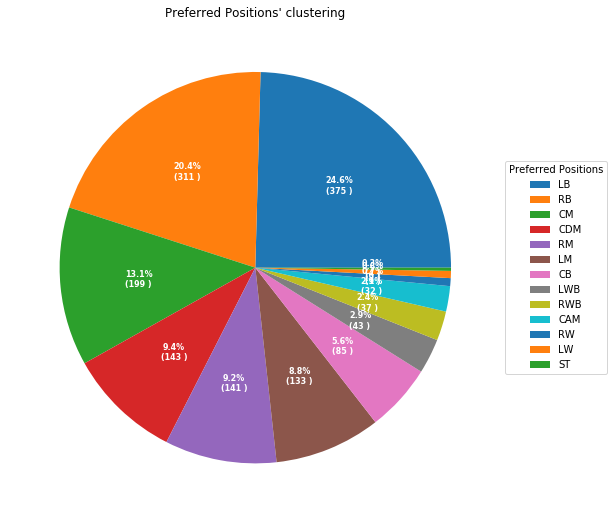

In [26]:
clusters = KMeans.train(featureData2, 12, maxIterations=10, initializationMode="random")

predictions = featureData.map( lambda kv: (clusters.predict( kv[1]) , kv[0]) )
print predictions.take(10)

for i in range(12):
    
    cluster = predictions.filter(lambda kv: int(kv[0]) ==i)# find the dataset belongs to cluster i
    cluster = cluster.map(lambda x: (x[1],1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x :-x[1]) # combine every int and count 
    x = cluster.map(lambda x: x[0]).collect() # all ingredients in this cluster
    y = cluster.map(lambda x: x[1]).collect() # corrsponding numbers
    
    print 'For cluster %d'%i 
    
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(aspect="equal"))

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} )".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(y, autopct=lambda pct: func(pct, y),
                                      textprops=dict(color="w"))

    ax.legend(wedges, x,
              title="Preferred Positions",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Preferred Positions' clustering")
    
    plt.savefig("Cluster_%d.jpg"%i)

    plt.show()

# Task #3 



In [ ]:
# Task 3.1 Use the abilty score to predice the preferred postition and the total score using multiclass logistic regression

In [ ]:
# preferred postition 

In [7]:
keylist = cleandata.map(lambda x: x.split(',')[63]).map(lambda x: x.split()[0])\
                   .map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).map(lambda x: x[0]).collect()
print keylist

[u'RWB', u'LB', u'CAM', u'CM', u'RB', u'LWB', u'GK', u'RW', u'CDM', u'LM', u'CF', u'ST', u'LW', u'CB', u'RM']


In [8]:
key = {}

for i, f in enumerate(keylist):
    key[f] = float(i)
    
c = len(keylist)

print "I have ",c, "keys"

print key

I have  15 keys
{u'RWB': 0.0, u'RW': 7.0, u'LB': 1.0, u'CAM': 2.0, u'CM': 3.0, u'CDM': 8.0, u'LM': 9.0, u'CF': 10.0, u'ST': 11.0, u'LW': 12.0, u'RB': 4.0, u'CB': 13.0, u'LWB': 5.0, u'RM': 14.0, u'GK': 6.0}


In [9]:
from pyspark.ml.linalg import Vectors
def buildFeatures2(line):
    d = line.split(",")
    Key = int(key[d[63].split()[0]])
    value = []
    for v in d[13:46]:
        v_true = v.split('-')[0]
        v_true = v_true.split('+')[0]
        value.append(float(v_true))
    return Key, Vectors.dense(value)
featureData3 = cleandata.map(buildFeatures2)
print featureData3.take(10)

[(11, DenseVector([89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0])), (7, DenseVector([92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0])), (12, DenseVector([94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0])), (11, DenseVector([88.0, 78.0, 86.0, 60.0, 91.0, 83.0, 77.0, 86.0, 86.0, 94.0, 84.0, 27.0, 25.0, 31.0, 33.0, 37.0, 77.0, 41.0, 69.0, 64.0, 86.0, 30.0, 85.0, 92.0, 93.0, 83.0, 87.0, 38.0, 77.0, 89.0, 45.0, 80.0, 84.0])), (6, DenseVector([58.0, 29.0, 52.0, 35.0, 48.0, 70.0, 15.0, 14.0, 30.0, 13.0, 11.0, 91.0, 90.0, 95.0, 91.0, 89.0, 25.0, 30.0, 78.0

In [10]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
featureData2DF = featureData3.map(lambda x: (x[0], x[1])).toDF(["labels", "features" ])
featureData2DF.show(20)

+------+--------------------+
|labels|            features|
+------+--------------------+
|    11|[89.0,63.0,89.0,6...|
|     7|[92.0,48.0,90.0,9...|
|    12|[94.0,56.0,96.0,8...|
|    11|[88.0,78.0,86.0,6...|
|     6|[58.0,29.0,52.0,3...|
|    11|[79.0,80.0,78.0,8...|
|     6|[57.0,38.0,60.0,4...|
|    12|[93.0,54.0,93.0,9...|
|     8|[60.0,60.0,71.0,6...|
|    11|[78.0,50.0,75.0,6...|
|    13|[75.0,84.0,79.0,6...|
|    14|[76.0,68.0,80.0,7...|
|     6|[46.0,23.0,61.0,4...|
|    14|[88.0,80.0,90.0,8...|
|     8|[75.0,62.0,93.0,9...|
|     7|[93.0,65.0,77.0,6...|
|    11|[90.0,63.0,86.0,9...|
|    13|[68.0,92.0,59.0,6...|
|     6|[49.0,38.0,55.0,4...|
|    11|[88.0,48.0,91.0,8...|
+------+--------------------+
only showing top 20 rows



In [22]:
TrainData2,TestData2 = featureData2DF.randomSplit([0.7,0.3])
TrainData2.show(20)
TestData2.show(20)

+------+--------------------+
|labels|            features|
+------+--------------------+
|     0|[50.0,82.0,54.0,6...|
|     0|[67.0,75.0,75.0,7...|
|     0|[68.0,71.0,64.0,7...|
|     0|[68.0,74.0,68.0,7...|
|     0|[69.0,72.0,72.0,7...|
|     0|[70.0,67.0,66.0,6...|
|     0|[71.0,70.0,76.0,7...|
|     0|[71.0,71.0,72.0,8...|
|     0|[72.0,68.0,72.0,8...|
|     0|[72.0,84.0,71.0,6...|
|     0|[73.0,45.0,70.0,6...|
|     0|[73.0,62.0,81.0,6...|
|     0|[73.0,63.0,65.0,6...|
|     0|[74.0,39.0,59.0,6...|
|     0|[74.0,65.0,71.0,6...|
|     0|[74.0,70.0,68.0,6...|
|     0|[74.0,74.0,78.0,8...|
|     0|[75.0,62.0,73.0,7...|
|     0|[75.0,64.0,71.0,7...|
|     0|[75.0,69.0,73.0,6...|
+------+--------------------+
only showing top 20 rows

+------+--------------------+
|labels|            features|
+------+--------------------+
|     0|[61.0,50.0,73.0,6...|
|     0|[62.0,77.0,60.0,5...|
|     0|[65.0,62.0,79.0,7...|
|     0|[69.0,60.0,73.0,7...|
|     0|[69.0,86.0,62.0,7...|
|     0|[70.0,

In [23]:
from pyspark.ml.classification import LogisticRegression
lr2 = LogisticRegression(labelCol="labels", featuresCol="features")
lrModel2 = lr2.fit(TrainData2)

In [25]:
prediction_and_labels2 = lrModel2.evaluate(TestData2)
prediction_and_labels2.predictions.show(40)


+------+--------------------+--------------------+--------------------+----------+
|labels|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|     0|[61.0,50.0,73.0,6...|[2.30012557771713...|[0.00474273862256...|      13.0|
|     0|[62.0,77.0,60.0,5...|[1.87438145497440...|[0.00356273799517...|      13.0|
|     0|[65.0,62.0,79.0,7...|[2.64142691887293...|[0.01814174528227...|       1.0|
|     0|[69.0,60.0,73.0,7...|[2.98033522064464...|[0.01714088117386...|       1.0|
|     0|[69.0,86.0,62.0,7...|[3.30167824578475...|[0.01218136938195...|       4.0|
|     0|[70.0,87.0,66.0,6...|[3.80133742320593...|[0.04591809468276...|       4.0|
|     0|[71.0,55.0,69.0,6...|[3.36433955596440...|[0.03654428226944...|       4.0|
|     0|[73.0,56.0,59.0,7...|[3.11465685740328...|[0.03470397689892...|       1.0|
|     0|[73.0,74.0,75.0,8...|[1.44768611907753...|[0.00633077820794...|       3.0|
|   

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [27]:
my_eval2 = MulticlassClassificationEvaluator(labelCol="labels",predictionCol="prediction")
print (my_eval2.evaluate(prediction_and_labels2.predictions))

0.495380377527


In [43]:
from pyspark.ml.linalg import Vectors
def buildFeatures3(line):
    d = line.split(",")
    Key = math.floor(int(d[6])/5.0)
    value = []
    for v in d[13:46]:
        v_true = v.split('-')[0]
        v_true = v_true.split('+')[0]
        value.append(float(v_true))
    return Key, Vectors.dense(value)
featureData4 = cleandata.map(buildFeatures3)
print featureData4.take(10)

[(18.0, DenseVector([89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0])), (18.0, DenseVector([92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0])), (18.0, DenseVector([94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0])), (18.0, DenseVector([88.0, 78.0, 86.0, 60.0, 91.0, 83.0, 77.0, 86.0, 86.0, 94.0, 84.0, 27.0, 25.0, 31.0, 33.0, 37.0, 77.0, 41.0, 69.0, 64.0, 86.0, 30.0, 85.0, 92.0, 93.0, 83.0, 87.0, 38.0, 77.0, 89.0, 45.0, 80.0, 84.0])), (18.0, DenseVector([58.0, 29.0, 52.0, 35.0, 48.0, 70.0, 15.0, 14.0, 30.0, 13.0, 11.0, 91.0, 90.0, 95.0, 91.0, 89.0, 25.0

In [44]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
featureData3DF = featureData4.map(lambda x: (x[0], x[1])).toDF(["labels", "features" ])
featureData3DF.show(20)

+------+--------------------+
|labels|            features|
+------+--------------------+
|  18.0|[89.0,63.0,89.0,6...|
|  18.0|[92.0,48.0,90.0,9...|
|  18.0|[94.0,56.0,96.0,8...|
|  18.0|[88.0,78.0,86.0,6...|
|  18.0|[58.0,29.0,52.0,3...|
|  18.0|[79.0,80.0,78.0,8...|
|  18.0|[57.0,38.0,60.0,4...|
|  18.0|[93.0,54.0,93.0,9...|
|  18.0|[60.0,60.0,71.0,6...|
|  18.0|[78.0,50.0,75.0,6...|
|  18.0|[75.0,84.0,79.0,6...|
|  17.0|[76.0,68.0,80.0,7...|
|  17.0|[46.0,23.0,61.0,4...|
|  17.0|[88.0,80.0,90.0,8...|
|  17.0|[75.0,62.0,93.0,9...|
|  17.0|[93.0,65.0,77.0,6...|
|  17.0|[90.0,63.0,86.0,9...|
|  17.0|[68.0,92.0,59.0,6...|
|  17.0|[49.0,38.0,55.0,4...|
|  17.0|[88.0,48.0,91.0,8...|
+------+--------------------+
only showing top 20 rows



In [45]:
TrainData3,TestData3 = featureData3DF.randomSplit([0.7,0.3])
TrainData3.show(20)
TestData3.show(20)

+------+--------------------+
|labels|            features|
+------+--------------------+
|  13.0|[15.0,22.0,36.0,3...|
|  13.0|[16.0,30.0,19.0,2...|
|  13.0|[19.0,25.0,30.0,2...|
|  13.0|[20.0,27.0,38.0,3...|
|  13.0|[22.0,13.0,55.0,3...|
|  13.0|[22.0,31.0,25.0,2...|
|  13.0|[22.0,32.0,49.0,3...|
|  13.0|[22.0,36.0,39.0,2...|
|  13.0|[22.0,36.0,39.0,2...|
|  13.0|[23.0,13.0,23.0,4...|
|  13.0|[23.0,22.0,48.0,2...|
|  13.0|[23.0,24.0,22.0,2...|
|  13.0|[25.0,27.0,34.0,3...|
|  13.0|[26.0,31.0,52.0,5...|
|  13.0|[27.0,17.0,23.0,2...|
|  13.0|[27.0,35.0,31.0,4...|
|  13.0|[28.0,35.0,39.0,3...|
|  13.0|[29.0,15.0,39.0,3...|
|  13.0|[29.0,22.0,39.0,3...|
|  13.0|[29.0,28.0,37.0,3...|
+------+--------------------+
only showing top 20 rows

+------+--------------------+
|labels|            features|
+------+--------------------+
|  13.0|[19.0,25.0,30.0,2...|
|  13.0|[20.0,19.0,17.0,1...|
|  13.0|[22.0,21.0,24.0,5...|
|  13.0|[24.0,31.0,27.0,4...|
|  13.0|[25.0,21.0,25.0,5...|
|  13.0|[27.0,

In [46]:
from pyspark.ml.classification import LogisticRegression
lr3 = LogisticRegression(labelCol="labels", featuresCol="features")
lrModel3 = lr3.fit(TrainData3)

In [47]:
prediction_and_labels3 = lrModel3.evaluate(TestData3)
prediction_and_labels3.predictions.show(40)

+------+--------------------+--------------------+--------------------+----------+
|labels|            features|       rawPrediction|         probability|prediction|
+------+--------------------+--------------------+--------------------+----------+
|  13.0|[19.0,25.0,30.0,2...|[-4.1069694664896...|[3.49380095223068...|      12.0|
|  13.0|[20.0,19.0,17.0,1...|[-4.0522464412357...|[5.19335846399361...|      14.0|
|  13.0|[22.0,21.0,24.0,5...|[-4.0981575409887...|[1.07498321744176...|      14.0|
|  13.0|[24.0,31.0,27.0,4...|[-4.2770555500832...|[8.03336990948420...|      14.0|
|  13.0|[25.0,21.0,25.0,5...|[-4.3682715765545...|[7.16041722907893...|      11.0|
|  13.0|[27.0,23.0,35.0,2...|[-4.1983905998415...|[4.61814487985641...|      12.0|
|  13.0|[27.0,31.0,37.0,3...|[-4.3005329408421...|[2.94998297988906...|      13.0|
|  13.0|[28.0,26.0,36.0,2...|[-4.2211386915134...|[3.42442717918577...|      14.0|
|  13.0|[28.0,27.0,18.0,2...|[-4.0808420273208...|[2.50537848319893...|      15.0|
|  1

In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [49]:
my_eval3 = MulticlassClassificationEvaluator(labelCol="labels",predictionCol="prediction")
print (my_eval3.evaluate(prediction_and_labels3.predictions))

0.388826239448


In [ ]:
# Here we set 0-4  as stage 1 and 90-94 as stage 18 , the accuary is still 0.38882. while we use the raw data to predict , the accuary is 0.07. 
# Which means it is so hard to predict the palyers' overall score only by the abilities. So what should we consider about ?


In [ ]:
# Task 3.2  Try to build a latent factor model for players' position score. Here, GK is totally different, so we ignore it. 


In [70]:
# First build the right data form we want 

def buildFeatures4(x):
    Key = int(x[0])+1
    index = []
    value = []
    for i in range(47,75):
        if i !=52 and i != 63:
            index.append(i)
            value.append(float(x[i]))
    return Key, index,value
LatentRawdata = cleandata.map(lambda x: x.split(',')).filter(lambda x: x[63]!='GK ').map(buildFeatures4)
print LatentRawdata.take(10)

[(1, [47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], [89.0, 53.0, 62.0, 91.0, 82.0, 89.0, 61.0, 53.0, 82.0, 62.0, 91.0, 89.0, 92.0, 91.0, 66.0, 89.0, 61.0, 53.0, 82.0, 62.0, 91.0, 89.0, 92.0, 91.0, 66.0, 92.0]), (2, [47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], [92.0, 45.0, 59.0, 92.0, 84.0, 92.0, 57.0, 45.0, 84.0, 59.0, 92.0, 90.0, 88.0, 91.0, 62.0, 92.0, 57.0, 45.0, 84.0, 59.0, 92.0, 90.0, 88.0, 91.0, 62.0, 88.0]), (3, [47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], [88.0, 46.0, 59.0, 88.0, 79.0, 88.0, 59.0, 46.0, 79.0, 59.0, 88.0, 87.0, 84.0, 89.0, 64.0, 88.0, 59.0, 46.0, 79.0, 59.0, 88.0, 87.0, 84.0, 89.0, 64.0, 84.0]), (4, [47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], [87.0, 58.0, 65.0, 88.0, 80.0, 87.0, 64.0, 58.0, 80.0, 65.0, 88.0, 85.0, 88.0, 87.

In [94]:
print len(LatentRawdata.collect())

15952


In [95]:
def buildFeatures5(x):
    Key = x[0]
    feature = []
    for i in range(26):
        feature.append ((Key,x[1][i],x[2][i]))
    return feature
Latentdata = LatentRawdata.flatMap(buildFeatures5)
print Latentdata.take(10)

[(1, 47, 89.0), (1, 48, 53.0), (1, 49, 62.0), (1, 50, 91.0), (1, 51, 82.0), (1, 53, 89.0), (1, 54, 61.0), (1, 55, 53.0), (1, 56, 82.0), (1, 57, 62.0)]


In [82]:
Name = {}

for i, f in enumerate(indexname):
    Name[i] = f
    
c = len(indexname)

print Name

{0: u'', 1: u'Name', 2: u'Age', 3: u'Photo', 4: u'Nationality', 5: u'Flag', 6: u'Overall', 7: u'Potential', 8: u'Club', 9: u'Club Logo', 10: u'Value', 11: u'Wage', 12: u'Special', 13: u'Acceleration', 14: u'Aggression', 15: u'Agility', 16: u'Balance', 17: u'Ball control', 18: u'Composure', 19: u'Crossing', 20: u'Curve', 21: u'Dribbling', 22: u'Finishing', 23: u'Free kick accuracy', 24: u'GK diving', 25: u'GK handling', 26: u'GK kicking', 27: u'GK positioning', 28: u'GK reflexes', 29: u'Heading accuracy', 30: u'Interceptions', 31: u'Jumping', 32: u'Long passing', 33: u'Long shots', 34: u'Marking', 35: u'Penalties', 36: u'Positioning', 37: u'Reactions', 38: u'Short passing', 39: u'Shot power', 40: u'Sliding tackle', 41: u'Sprint speed', 42: u'Stamina', 43: u'Standing tackle', 44: u'Strength', 45: u'Vision', 46: u'Volleys', 47: u'CAM', 48: u'CB', 49: u'CDM', 50: u'CF', 51: u'CM', 52: u'ID', 53: u'LAM', 54: u'LB', 55: u'LCB', 56: u'LCM', 57: u'LDM', 58: u'LF', 59: u'LM', 60: u'LS', 61: u'L

In [83]:
Name[63]

u'Preferred Positions'

In [96]:
# Second, we need train the Latent model 
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
ratings = Latentdata.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2]))).cache()

# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
print predictions.take(10)
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
print ratesAndPreds.take(10)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

RMSE = sqrt(MSE)
print("Root Mean Squared Error = " + str(RMSE))


[((4904, 66), 43.94097315324271), ((4904, 54), 41.33689358602358), ((4904, 50), 63.772546145845155), ((4904, 62), 42.40438443549566), ((4904, 74), 68.45622553407034), ((4904, 70), 58.05255031822679), ((4904, 58), 63.772546145845155), ((4904, 61), 59.04054706632734), ((4904, 53), 60.87744832547313), ((4904, 65), 41.33689358602358)]
[((8007, 67), (57.0, 56.886793211937054)), ((13489, 51), (56.0, 55.89113515603711)), ((2439, 73), (49.0, 49.26478293287544)), ((9920, 58), (66.0, 65.78303263227838)), ((10349, 65), (54.0, 54.0296023950725)), ((9498, 64), (45.0, 45.080047962169836)), ((3949, 47), (45.0, 45.18606728818736)), ((13371, 51), (54.0, 53.878476421824864)), ((15930, 50), (59.0, 58.82293064455695)), ((4039, 55), (73.0, 72.64249803089872))]
Mean Squared Error = 0.02636405577
Root Mean Squared Error = 0.162370119696


In [109]:
print len(ratings.collect())

414752


In [97]:
print ratings.take(10)
print predictions.take(10)
print ratesAndPreds.take(10)

[Rating(user=1, product=47, rating=89.0), Rating(user=1, product=48, rating=53.0), Rating(user=1, product=49, rating=62.0), Rating(user=1, product=50, rating=91.0), Rating(user=1, product=51, rating=82.0), Rating(user=1, product=53, rating=89.0), Rating(user=1, product=54, rating=61.0), Rating(user=1, product=55, rating=53.0), Rating(user=1, product=56, rating=82.0), Rating(user=1, product=57, rating=62.0)]
[((4904, 66), 43.94097315324271), ((4904, 54), 41.33689358602358), ((4904, 50), 63.772546145845155), ((4904, 62), 42.40438443549566), ((4904, 74), 68.45622553407034), ((4904, 70), 58.05255031822679), ((4904, 58), 63.772546145845155), ((4904, 61), 59.04054706632734), ((4904, 53), 60.87744832547313), ((4904, 65), 41.33689358602358)]
[((1723, 55), (68.0, 67.93933016190812)), ((13489, 51), (56.0, 55.89113515603711)), ((9920, 58), (66.0, 65.78303263227838)), ((8007, 67), (57.0, 56.886793211937054)), ((9498, 64), (45.0, 45.080047962169836)), ((3949, 47), (45.0, 45.18606728818736)), ((1330

Mean Squared Error = 3.0319084571
Mean Squared Error = 1.39404840665
Mean Squared Error = 0.347958051152
Mean Squared Error = 0.0761695909322
Mean Squared Error = 0.0552139489629
Mean Squared Error = 0.0284738045503
Mean Squared Error = 0.0202110659806


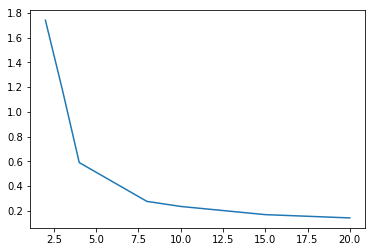

In [100]:
# Third,Try different values of rank (number of factors). For each compute the RMSE and make a plot. What have you observed?
rankset = [2,3,4,8,10,15,20]
RMSE = []
for rank in rankset:
    numIterations = 10
    model = ALS.train(ratings, rank, numIterations)

    # Evaluate the model on training data
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    print("Mean Squared Error = " + str(MSE))

    RMSE.append(sqrt(MSE))
plt.plot(rankset,RMSE)

In [102]:
# Forth, use baseline method to predict one player's position scores

playerBias = {}  # this should be a hash-table containing player averages
positionBias = {}  # this should be a hash-table containing position averages
mu = ratings.map(lambda r: r.rating).mean()
print "My average rating is:",mu

playerRating =  ratings.map(lambda r: (r.user, np.array([r.rating,1]))).reduceByKey(lambda x,y: x+y)\
           .map(lambda d:  (d[0], d[1][0]/d[1][1]  ) ).collect()
    
for e in  playerRating:
    playerBias[e[0]]= e[1]-mu
print playerBias     

My average rating is: 58.0929254108
{1: 19.63784381992088, 2: 18.060920742997816, 3: 16.13784381992088, 4: 19.060920742997816, 6: 16.445536127613188, 8: 16.291689973767042, 9: 21.753228435305495, 10: 11.022459204536268, 11: 17.983997666074735, 12: 18.945536127613188, 14: 17.060920742997816, 15: 22.63784381992088, 16: 21.791689973767042, 17: 13.099382281459349, 18: 7.560920742997816, 20: 13.791689973767042, 22: 14.099382281459349, 23: 20.560920742997816, 24: 14.830151512228575, 25: 14.868613050690122, 26: 15.060920742997816, 27: 12.291689973767042, 28: 17.060920742997816, 29: 11.599382281459349, 31: 17.09938228145935, 32: 13.753228435305495, 33: 14.983997666074735, 34: 20.907074589151655, 35: 20.983997666074735, 36: 22.253228435305495, 37: 16.67630535838243, 38: 24.09938228145935, 39: 14.522459204536268, 40: 22.483997666074735, 41: 22.09938228145935, 42: 18.945536127613188, 43: 14.253228435305495, 45: 15.291689973767042, 46: 19.560920742997816, 47: 13.907074589151655, 48: 15.29168997376

In [103]:
positionRating =  ratings.map(lambda r: (r.product, np.array([r.rating,1]))).reduceByKey(lambda x,y: x+y)\
           .map(lambda d:  (d[0], d[1][0]/d[1][1]  ) ).collect()
for e in  positionRating:
    positionBias[e[0]]= e[1]-mu
print positionBias 

{47: 1.1588298549490474, 48: -2.5424615191733224, 49: -1.2276420607981962, 50: 0.9371021718999017, 51: 0.41390758814864625, 53: 1.1588298549490474, 54: -1.11323634364674, 55: -2.5424615191733224, 56: 0.41390758814864625, 57: -1.2276420607981962, 58: 0.9371021718999017, 59: 1.964810296273022, 60: 0.11112423809849759, 61: 1.266339885039315, 62: -0.3942042473578766, 64: 1.1588298549490474, 65: -1.11323634364674, 66: -2.5424615191733224, 67: 0.41390758814864625, 68: -1.2276420607981962, 69: 0.9371021718999017, 70: 1.964810296273022, 71: 0.11112423809849759, 72: 1.266339885039315, 73: -0.3942042473578766, 74: 0.11112423809849759}


In [104]:
# Create my own player 
myRaitings={}  
myRaitings[47]=92  # CAM
myRaitings[48]=45  # CB
myRaitings[49]=59  # CDM
myRaitings[50]=92  # CF 
myRaitings[51]=84  # CM
myRaitings[74]=88  # ST

print myRaitings

{74: 88, 47: 92, 48: 45, 49: 59, 50: 92, 51: 84}


Now, we need one more MAP function which will create a new raitings, from which we subtract the baselines (i.e. the new raitings will be just deviations from baseline). Train the latent factor model on this new data. Plese also include yourself into dataset. See the code below to see how to "union" two RDDs   

In [106]:
myRaitingsData = []
for key in myRaitings:
    myRaitingsData.append( [0, key, myRaitings[key] ] )
myRaitingsDataRDD = sc.parallelize(myRaitingsData)    
print myRaitingsDataRDD.collect()

[[0, 74, 88], [0, 47, 92], [0, 48, 45], [0, 49, 59], [0, 50, 92], [0, 51, 84]]


In [108]:
print myRaitingsDataRDD.count()
print Latentdata.count()
ALL_DATA = myRaitingsDataRDD.union(Latentdata)
print ALL_DATA.count()
print ALL_DATA.take(10)

6
414752
414758
[[0, 74, 88], [0, 47, 92], [0, 48, 45], [0, 49, 59], [0, 50, 92], [0, 51, 84], (1, 47, 89.0), (1, 48, 53.0), (1, 49, 62.0), (1, 50, 91.0)]


In [110]:
playerBias[0] = sum(myRaitings.values())/6.0 - mu
print playerBias[0]

18.5737412558


In [111]:
finalTrainData = ALL_DATA .map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2]))).cache()
print finalTrainData.take(10)

[Rating(user=0, product=74, rating=88.0), Rating(user=0, product=47, rating=92.0), Rating(user=0, product=48, rating=45.0), Rating(user=0, product=49, rating=59.0), Rating(user=0, product=50, rating=92.0), Rating(user=0, product=51, rating=84.0), Rating(user=1, product=47, rating=89.0), Rating(user=1, product=48, rating=53.0), Rating(user=1, product=49, rating=62.0), Rating(user=1, product=50, rating=91.0)]


In [114]:
def removeBaseline(r):  # this removes the baseline rating from the training data
    baselineEstimate = mu+ playerBias[r.user]  +  positionBias[r.product]
    
    return Rating(r.user,r.product,r.rating - baselineEstimate)
print finalTrainData.take(10)    
print "\n"
print mu, playerBias[0], positionBias[47]   
print "\n"
print finalTrainData.map(removeBaseline) .take(10)  

 [Rating(user=0, product=74, rating=88.0), Rating(user=0, product=47, rating=92.0), Rating(user=0, product=48, rating=45.0), Rating(user=0, product=49, rating=59.0), Rating(user=0, product=50, rating=92.0), Rating(user=0, product=51, rating=84.0), Rating(user=1, product=47, rating=89.0), Rating(user=1, product=48, rating=53.0), Rating(user=1, product=49, rating=62.0), Rating(user=1, product=50, rating=91.0)]


58.0929254108 18.5737412558 1.1588298549490474


[Rating(user=0, product=74, rating=11.222209095234831), Rating(user=0, product=47, rating=14.174503478384281), Rating(user=0, product=48, rating=-29.124205147493342), Rating(user=0, product=49, rating=-16.439024605868468), Rating(user=0, product=50, rating=14.396231161433434), Rating(user=0, product=51, rating=6.919425745184682), Rating(user=1, product=47, rating=10.110400914281726), Rating(user=1, product=48, rating=-22.18830771159591), Rating(user=1, product=49, rating=-14.503127169971037), Rating(user=1, product=50, rating=12.33

In [115]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
ratingsWithRemovedBaseline = finalTrainData.map(removeBaseline)
model = ALS.train(ratingsWithRemovedBaseline, rank, numIterations)

In [116]:
# Then write a code to recommend the top 5 position this player should play

allPositionsRDD = sc.parallelize( positionBias.keys())
print allPositionsRDD.take(5)

predictForMe = allPositionsRDD.map(lambda d: (0,d)  )
print predictForMe.take(5)

predForMe = model.predictAll(predictForMe)
print "\n\n"
print predForMe.take(5)

[47, 48, 49, 50, 51]
[(0, 47), (0, 48), (0, 49), (0, 50), (0, 51)]



[Rating(user=0, product=66, rating=-28.736591588089237), Rating(user=0, product=54, rating=-9.772618064301312), Rating(user=0, product=48, rating=-28.735998026098713), Rating(user=0, product=57, rating=-16.173512933538532), Rating(user=0, product=51, rating=6.816501262316305)]


In [117]:
def addBaselineEstimate(r):
    baselineEstimate = mu+ playerBias[r.user]  +  positionBias[r.product]
    
    return Rating(r.user,r.product,r.rating + baselineEstimate)
 
print predForMe.map(addBaselineEstimate).take(5)

[Rating(user=0, product=66, rating=45.3876135594041), Rating(user=0, product=54, rating=65.78081225871863), Rating(user=0, product=48, rating=45.38820712139463), Rating(user=0, product=57, rating=59.265511672329936), Rating(user=0, product=51, rating=83.89707551713163)]


In [119]:
BestPositions = predForMe.map(addBaselineEstimate).takeOrdered(7, lambda r: -r.rating)
for r in BestPositions:
    print r.product,Name[r.product], r.rating

69 RF 91.8464483795
58 LF 91.8464483795
50 CF 91.8460190313
47 CAM 91.7862263499
64 RAM 91.7859454993
53 LAM 91.7859454993
60 LS 87.9203891555


# Task #4 
 

In [14]:
from pyspark.mllib.linalg import Vectors
featureData5 = cleandata.map(buildFeatures2)
print featureData5.take(10)

[(11, DenseVector([89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0])), (7, DenseVector([92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0])), (12, DenseVector([94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0])), (11, DenseVector([88.0, 78.0, 86.0, 60.0, 91.0, 83.0, 77.0, 86.0, 86.0, 94.0, 84.0, 27.0, 25.0, 31.0, 33.0, 37.0, 77.0, 41.0, 69.0, 64.0, 86.0, 30.0, 85.0, 92.0, 93.0, 83.0, 87.0, 38.0, 77.0, 89.0, 45.0, 80.0, 84.0])), (6, DenseVector([58.0, 29.0, 52.0, 35.0, 48.0, 70.0, 15.0, 14.0, 30.0, 13.0, 11.0, 91.0, 90.0, 95.0, 91.0, 89.0, 25.0, 30.0, 78.0

In [15]:
from pyspark.mllib.linalg.distributed import RowMatrix
rows = featureData5.map(lambda kv: kv[1]) 
mat = RowMatrix(rows)
print mat 
svd = mat.computeSVD(2, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V2D = svd.V       # The V factor is a local dense matrix.

# print s  # vector
# print U  # RDD
print V2D  # matrix


DenseMatrix([[ 0.21873358,  0.03364024],
             [ 0.19109695, -0.01552566],
             [ 0.21472877,  0.04096422],
             [ 0.21503317,  0.05959721],
             [ 0.20093721, -0.09500228],
             [ 0.1968951 ,  0.03237073],
             [ 0.17384097, -0.11673594],
             [ 0.16535694, -0.11067073],
             [ 0.19170592, -0.13251199],
             [ 0.15774255, -0.10991741],
             [ 0.15077508, -0.09576837],
             [ 0.04613329,  0.39464406],
             [ 0.04580767,  0.3784479 ],
             [ 0.04563432,  0.36903074],
             [ 0.04574223,  0.38050314],
             [ 0.04642433,  0.40065244],
             [ 0.17983864, -0.07996184],
             [ 0.16068905, -0.04721627],
             [ 0.21557045,  0.18794764],
             [ 0.18068091, -0.04021601],
             [ 0.16533268, -0.12048477],
             [ 0.15235266, -0.06571839],
             [ 0.16844272, -0.0578609 ],
             [ 0.17344888, -0.13108517],
             [ 0

In [18]:

svd = mat.computeSVD(3, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V3D = svd.V       # The V factor is a local dense matrix.

# print s  # vector
# print U  # RDD
print V3D  # matrix


DenseMatrix([[-0.21873358,  0.03364024, -0.10504499],
             [-0.19109695, -0.01552566,  0.20057478],
             [-0.21472877,  0.04096422, -0.12994835],
             [-0.21503317,  0.05959721, -0.09520406],
             [-0.20093721, -0.09500228, -0.07122561],
             [-0.1968951 ,  0.03237073, -0.00394721],
             [-0.17384097, -0.11673594, -0.05990843],
             [-0.16535694, -0.11067073, -0.13880019],
             [-0.19170592, -0.13251199, -0.14226527],
             [-0.15774255, -0.10991741, -0.26757389],
             [-0.15077508, -0.09576837, -0.10773417],
             [-0.04613329,  0.39464406, -0.02939596],
             [-0.04580767,  0.3784479 , -0.02863491],
             [-0.04563432,  0.36903074, -0.02827014],
             [-0.04574223,  0.38050314, -0.02764158],
             [-0.04642433,  0.40065244, -0.03029858],
             [-0.17983864, -0.07996184,  0.10535864],
             [-0.16068905, -0.04721627,  0.36660036],
             [-0.21557045,  

In [28]:
# choose three position and color them in the plot
transdic = {
    6:0,
    7:1,
    11:2
}
def parseData(data):
    return [ int(transdic[data[0]]),  data[1]]
print featureData5.take(5)
parsedData1 = featureData5.filter(lambda x :x[0] == 6).map(parseData).collect()[0:100] # GK
parsedData2 = featureData5.filter(lambda x :x[0] == 7).map(parseData).collect()[0:100] # RW
parsedData3 = featureData5.filter(lambda x :x[0] == 11).map(parseData).collect()[0:100] # ST
parsedData1.extend(parsedData2)
parsedData1.extend(parsedData3)
print parsedData1[101]
print len(parsedData1)

[(11, DenseVector([89.0, 63.0, 89.0, 63.0, 93.0, 95.0, 85.0, 81.0, 91.0, 94.0, 76.0, 7.0, 11.0, 15.0, 14.0, 11.0, 88.0, 29.0, 95.0, 77.0, 92.0, 22.0, 85.0, 95.0, 96.0, 83.0, 94.0, 23.0, 91.0, 92.0, 31.0, 80.0, 85.0])), (7, DenseVector([92.0, 48.0, 90.0, 95.0, 95.0, 96.0, 77.0, 89.0, 97.0, 95.0, 90.0, 6.0, 11.0, 15.0, 14.0, 8.0, 71.0, 22.0, 68.0, 87.0, 88.0, 13.0, 74.0, 93.0, 95.0, 88.0, 85.0, 26.0, 87.0, 73.0, 28.0, 59.0, 90.0])), (12, DenseVector([94.0, 56.0, 96.0, 82.0, 95.0, 92.0, 75.0, 81.0, 96.0, 89.0, 84.0, 9.0, 9.0, 15.0, 15.0, 11.0, 62.0, 36.0, 61.0, 75.0, 77.0, 21.0, 81.0, 90.0, 88.0, 81.0, 80.0, 33.0, 90.0, 78.0, 24.0, 53.0, 80.0])), (11, DenseVector([88.0, 78.0, 86.0, 60.0, 91.0, 83.0, 77.0, 86.0, 86.0, 94.0, 84.0, 27.0, 25.0, 31.0, 33.0, 37.0, 77.0, 41.0, 69.0, 64.0, 86.0, 30.0, 85.0, 92.0, 93.0, 83.0, 87.0, 38.0, 77.0, 89.0, 45.0, 80.0, 84.0])), (6, DenseVector([58.0, 29.0, 52.0, 35.0, 48.0, 70.0, 15.0, 14.0, 30.0, 13.0, 11.0, 91.0, 90.0, 95.0, 91.0, 89.0, 25.0, 30.0, 78.0

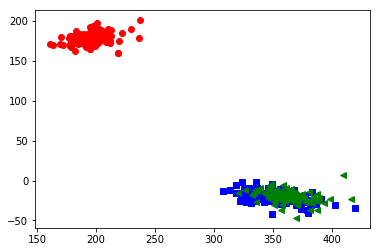

In [29]:
markers = ['ro','bs','g<']
for position in parsedData1:
    f =np.array(position[1])
    typ = position[0]
    f = f.dot(V2D.toArray())

    plt.plot( f[0], f[1], markers[typ] )


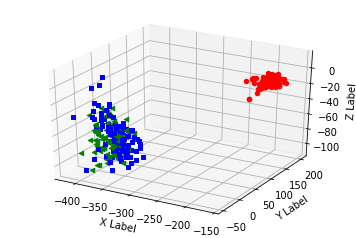

In [30]:

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = plt.axes(projection='3d')


colors = ['r','b','g']
markers = ['o','s','<']
for position in parsedData1:
    f =np.array(position[1])
    typ = position[0]
    f = f.dot(V3D.toArray())

    ax.scatter( f[0], f[1], f[2],c = colors[typ], marker = markers[typ] )

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
# From these plots, we could see the difference between GK RW ST

# Task #5 
 

In [ ]:
# Try to use something we didnt learn in the class to explore the dataset. 
# Here we introduce panda dataframe to do some data manipulation 
 

In [7]:
import pandas as pd 
df = pd.read_csv('CompleteDataset.csv')
print df.columns
# print df.head(10)

Index([u'Unnamed: 0', u'Name', u'Age', u'Photo', u'Nationality', u'Flag',
       u'Overall', u'Potential', u'Club', u'Club Logo', u'Value', u'Wage',
       u'Special', u'Acceleration', u'Aggression', u'Agility', u'Balance',
       u'Ball control', u'Composure', u'Crossing', u'Curve', u'Dribbling',
       u'Finishing', u'Free kick accuracy', u'GK diving', u'GK handling',
       u'GK kicking', u'GK positioning', u'GK reflexes', u'Heading accuracy',
       u'Interceptions', u'Jumping', u'Long passing', u'Long shots',
       u'Marking', u'Penalties', u'Positioning', u'Reactions',
       u'Short passing', u'Shot power', u'Sliding tackle', u'Sprint speed',
       u'Stamina', u'Standing tackle', u'Strength', u'Vision', u'Volleys',
       u'CAM', u'CB', u'CDM', u'CF', u'CM', u'ID', u'LAM', u'LB', u'LCB',
       u'LCM', u'LDM', u'LF', u'LM', u'LS', u'LW', u'LWB',
       u'Preferred Positions', u'RAM', u'RB', u'RCB', u'RCM', u'RDM', u'RF',
       u'RM', u'RS', u'RW', u'RWB', u'ST'],
      dtype=

In [9]:
df1 = df[['Name', 'Age','Nationality','Overall','Potential','Club','Value','Wage',]]
print df1.head(10)

                Name  Age Nationality  Overall  Potential  \
0  Cristiano Ronaldo   32    Portugal       94         94   
1           L. Messi   30   Argentina       93         93   
2             Neymar   25      Brazil       92         94   
3          L. Suárez   30     Uruguay       92         92   
4           M. Neuer   31     Germany       92         92   
5     R. Lewandowski   28      Poland       91         91   
6             De Gea   26       Spain       90         92   
7          E. Hazard   26     Belgium       90         91   
8           T. Kroos   27     Germany       90         90   
9         G. Higuaín   29   Argentina       90         90   

                  Club   Value   Wage  
0       Real Madrid CF  €95.5M  €565K  
1         FC Barcelona   €105M  €565K  
2  Paris Saint-Germain   €123M  €280K  
3         FC Barcelona    €97M  €510K  
4     FC Bayern Munich    €61M  €230K  
5     FC Bayern Munich    €92M  €355K  
6    Manchester United  €64.5M  €215K  
7       

In [31]:
df1['Value(M)'] = np.where(df1['Value'].str[-1] == '0', \
                           0,\
                           df1['Value'].str[3:-1].replace(r'[a-zA-Z]',''))
df1['Value(M)'] = df1['Value(M)'].astype(float)
df1['Value(M)'] = np.where(df1['Value'].str[-1] == 'M', \
                           df1['Value(M)'],\
                           df1['Value(M)']/1000.0)
df1.head(10)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Value(M)
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,95.5
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,105.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,123.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,97.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,61.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,92.0
6,De Gea,26,Spain,90,92,Manchester United,€64.5M,€215K,64.5
7,E. Hazard,26,Belgium,90,91,Chelsea,€90.5M,€295K,90.5
8,T. Kroos,27,Germany,90,90,Real Madrid CF,€79M,€340K,79.0
9,G. Higuaín,29,Argentina,90,90,Juventus,€77M,€275K,77.0


In [50]:
df1['Wage(K)'] = np.where(df1['Wage'].str[-1] == '0', \
                           0,\
                           df1['Wage'].str[3:-1].replace(r'[a-zA-Z]',''))
df1['Wage(K)'] = df1['Wage(K)'].astype(float)
# df1['Wage(K)'] = np.where(df1[''].str[-1] == 'M', \
#                            df1['Value(M)'],\
#                            df1['Value(M)']/1000.0)
df1.head(10)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Value(M),Wage(K)
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,95.5,565.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,105.0,565.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,123.0,280.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,97.0,510.0
4,M. Neuer,31,Germany,92,92,FC Bayern Munich,€61M,€230K,61.0,230.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,92.0,355.0
6,De Gea,26,Spain,90,92,Manchester United,€64.5M,€215K,64.5,215.0
7,E. Hazard,26,Belgium,90,91,Chelsea,€90.5M,€295K,90.5,295.0
8,T. Kroos,27,Germany,90,90,Real Madrid CF,€79M,€340K,79.0,340.0
9,G. Higuaín,29,Argentina,90,90,Juventus,€77M,€275K,77.0,275.0


Text(0.5,1,'Average Value by Age')

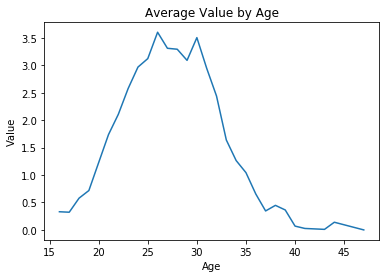

In [33]:
ValueByAge = df1.groupby(['Age'])['Value(M)'].mean()
ax = ValueByAge.plot()
ax.set_ylabel('Value')
ax.set_title('Average Value by Age')

Text(0.5,1,'Average Wage by Age')

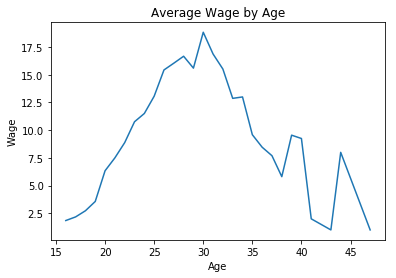

In [51]:
WageByAge = df1.groupby(['Age'])['Wage(K)'].mean()
ax = WageByAge.plot()
ax.set_ylabel('Wage')
ax.set_title('Average Wage by Age')

In [47]:
ValueByClub = df1.groupby(['Club'])['Value(M)'].mean()
ValueByClub = ValueByClub.sort_values(ascending=False)
print ValueByClub.head(10)

Club
Real Madrid CF         31.796154
FC Barcelona           29.780000
FC Bayern Munich       28.800962
Juventus               23.734615
Paris Saint-Germain    22.562500
Chelsea                20.396515
Manchester United      18.391176
Atlético Madrid        17.692187
Manchester City        17.521667
Tottenham Hotspur      16.154844
Name: Value(M), dtype: float64


In [49]:
ValueByClub2 = df1.groupby(['Club'])['Value(M)'].sum()
ValueByClub2 = ValueByClub2.sort_values(ascending=False)
print ValueByClub2.head(10)

Club
Real Madrid CF         826.700
FC Bayern Munich       748.825
FC Barcelona           744.500
Chelsea                673.085
Paris Saint-Germain    631.750
Manchester United      625.300
Juventus               617.100
Manchester City        578.215
Atlético Madrid        566.150
Tottenham Hotspur      516.955
Name: Value(M), dtype: float64


In [53]:
WageByClub = df1.groupby(['Club'])['Wage(K)'].mean()
WageByClub = WageByClub.sort_values(ascending=False)
print WageByClub.head(10)

Club
FC Barcelona           191.680000
Real Madrid CF         182.730769
FC Bayern Munich       125.884615
Juventus               121.730769
Manchester United      107.441176
Chelsea                107.181818
Manchester City         95.515152
Arsenal                 91.121212
Liverpool               83.250000
Paris Saint-Germain     78.500000
Name: Wage(K), dtype: float64


In [55]:
WageByClub2 = df1.groupby(['Club'])['Wage(K)'].sum()
WageByClub2 = WageByClub2.sort_values(ascending=False)
print WageByClub2.head(10)

Club
FC Barcelona         4792.0
Real Madrid CF       4751.0
Manchester United    3653.0
Chelsea              3537.0
FC Bayern Munich     3273.0
Juventus             3165.0
Manchester City      3152.0
Arsenal              3007.0
Liverpool            2664.0
Everton              2499.0
Name: Wage(K), dtype: float64


In [16]:
df2 = df1[df1['Value'].str[-1]=='0']
print df2.head(10)

                Name  Age     Nationality  Overall  Potential Club Value Wage
162            Oscar   25          Brazil       83         86  NaN    €0   €0
167     Adrien Silva   28        Portugal       83         83  NaN    €0   €0
274        A. Witsel   28         Belgium       82         82  NaN    €0   €0
472          M. Berg   30          Sweden       80         80  NaN    €0   €0
488   Renato Augusto   29          Brazil       80         80  NaN    €0   €0
658         Gervinho   30     Ivory Coast       79         79  NaN    €0   €0
925     B. Moukandjo   28        Cameroon       77         77  NaN    €0   €0
944        B. Dočkal   28  Czech Republic       77         77  NaN    €0   €0
1019             Gil   30          Brazil       77         77  NaN    €0   €0
1273      C. Riveros   34        Paraguay       76         76  NaN    €0   €0


Text(0.5,1,'Average Rating by Age')

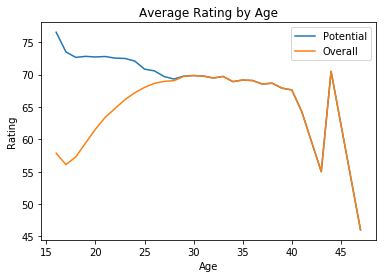

In [12]:
PotentialByAge = df1.groupby(['Age'])['Potential'].mean()
OverallByAge = df1.groupby(['Age'])['Overall'].mean()

Summary = pd.concat([PotentialByAge,OverallByAge],axis = 1)

ax = Summary.plot()
ax.set_ylabel('Rating')
ax.set_title('Average Rating by Age')

In [67]:
# 'ST', 'RW', 'LW', 'GK', 'CDM', 'CB', 'RM', 'CM', 'LM', 'LB', 'CAM','RB', 'CF', 'RWB', 'LWB'

def best_squad(position):
    df_copy = df.copy()
    store = []
    for i in position:
        if i !='GK':           
            store.append([i,df_copy.loc[[df_copy[i].idxmax()]]['Name']\
                          .to_string(index = False), df_copy[i].max()])
            df_copy.drop(df_copy[i].idxmax(), inplace = True)
        else:
            store.append([i,df_copy.loc[[df_copy[df_copy['ST'].isnull()]['Overall'].idxmax()]]['Name'].\
                          to_string(index = False), df_copy[df_copy['ST'].isnull()]['Overall'].max()])
            df_copy.drop(df_copy[df_copy['ST'].isnull()]['Overall'].idxmax(), inplace = True)
    #return store
    return pd.DataFrame(np.array(store).reshape(11,3), columns = ['Position', 'Player', 'Overall']).to_string(index = False)

# 4-3-3
squad_433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
print ('4-3-3')
print (best_squad(squad_433))

4-3-3
Position             Player Overall
     GK           M. Neuer      92
     LB       Sergio Ramos    84.0
     CB       G. Chiellini    86.0
     CB         L. Bonucci    86.0
     RB            Marcelo    84.0
     LM           L. Messi    90.0
    CDM           A. Vidal    85.0
     RM  Cristiano Ronaldo    89.0
     LW             Neymar    89.0
     ST          L. Suárez    88.0
     RW          E. Hazard    88.0


In [65]:
squad_433_2 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LW', 'ST', 'RW', 'LM', 'CDM', 'RM']
print ('4-3-3')
print (best_squad(squad_433_2))

4-3-3
Position             Player Overall
     GK           M. Neuer      92
     LB       Sergio Ramos    84.0
     CB       G. Chiellini    86.0
     CB         L. Bonucci    86.0
     RB            Marcelo    84.0
     LW  Cristiano Ronaldo    91.0
     ST           L. Messi    88.0
     RW             Neymar    89.0
     LM          E. Hazard    87.0
    CDM           A. Vidal    85.0
     RM            G. Bale    87.0
